In [75]:
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Read in the data

In [2]:
calendar = pd.read_csv('./data/archive/calendar.csv')
listings = pd.read_csv('./data/archive/listings.csv')
reviews = pd.read_csv('./data/archive/reviews.csv')

# Look at the columns of the data

In [3]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [4]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

# Questions that I would like to do with this EDA notebook on the data

1. Does having more pictures of the house correspond to higher overall reviews or prices for the location? 
   1. Which ones have a better correlation to the higher review?
      1. After some review it appears there is a good coorelation between including pictures and ratings.
      2. This could be just reflecting the overall reviews for the data though. 
2. Is square feet correlated to price?  
   1. Since there is only 97 rows with square feet not null, this questions will be excluded from investigation
   2. However, from the data present, there isn't any notable correlation between price and square feet
3. What feature correlates to higher prices? 
   1. Based on the coefficients for the logistical model, it looks like the three highest attributes to determine price is bathrooms, bedrooms and beds.
4. What feature correlate to higher overall review ratings? 
5. Does a word cloud give any interesting feedback into the reviews? 
6. What days are the most popular? Specifically Weekdays or Weekends? 
7. Does higher review count correspond to higher prices on the location? 
8. Does stay length correspond to rating review? 
9. Does host's response infromation coorelate to higher review or price? 
10. Does not having a picture correlate to not having a review?
   1. It does not. There is a good portion of na reviews that have pictures. 

# Does having more pictures of the house correspond to higher overall reviews or prices for the location? 

In [6]:
listings[['thumbnail_url','medium_url','xl_picture_url']].isna().mean()

thumbnail_url     0.083814
medium_url        0.083814
xl_picture_url    0.083814
dtype: float64

In [7]:
dataForPictureQuestion = listings[['thumbnail_url','medium_url','xl_picture_url','review_scores_value']].dropna(subset=['review_scores_value']).fillna(0)

In [8]:
def _fill_remaining_X(value):
    if value != 0: 
        return 1
    return 0

In [9]:
for col in dataForPictureQuestion[['thumbnail_url','medium_url','xl_picture_url']].columns: 
    dataForPictureQuestion[col] = dataForPictureQuestion[col].apply(_fill_remaining_X)

In [10]:
dataForPictureQuestion.head()

,thumbnail_url,medium_url,xl_picture_url,review_scores_value
0,0,0,0,10.0
1,1,1,1,10.0
2,0,0,0,10.0
4,0,0,0,9.0
5,1,1,1,10.0


In [11]:
dataForPictureQuestion[(dataForPictureQuestion['thumbnail_url'] == 1)]

,thumbnail_url,medium_url,xl_picture_url,review_scores_value
1,1,1,1,10.0
5,1,1,1,10.0
6,1,1,1,10.0
7,1,1,1,10.0
8,1,1,1,10.0
...,...,...,...,...
3810,1,1,1,8.0
3811,1,1,1,10.0
3812,1,1,1,10.0
3813,1,1,1,8.0


In [12]:
dataForPictureQuestion[(dataForPictureQuestion['medium_url'] == 1) & (dataForPictureQuestion['xl_picture_url'] == 1)]

,thumbnail_url,medium_url,xl_picture_url,review_scores_value
1,1,1,1,10.0
5,1,1,1,10.0
6,1,1,1,10.0
7,1,1,1,10.0
8,1,1,1,10.0
...,...,...,...,...
3810,1,1,1,8.0
3811,1,1,1,10.0
3812,1,1,1,10.0
3813,1,1,1,8.0


### It appears that if you have one picture in the listing, then you will have all of the pictures in the listing

In [13]:
listingsWithPictures = dataForPictureQuestion[dataForPictureQuestion['thumbnail_url'] == 1]

In [14]:
dummyListingsWithPicture = pd.get_dummies(listingsWithPictures[['review_scores_value']])

In [15]:
dummyListingsWithPicture.review_scores_value.unique()

array([10.,  9.,  8.,  6.,  7.,  4.,  2.,  5.])

In [16]:
dummyDataForPicture = pd.get_dummies(dataForPictureQuestion)

In [17]:
dummyDataForPicture.head()

,thumbnail_url,medium_url,xl_picture_url,review_scores_value
0,0,0,0,10.0
1,1,1,1,10.0
2,0,0,0,10.0
4,0,0,0,9.0
5,1,1,1,10.0


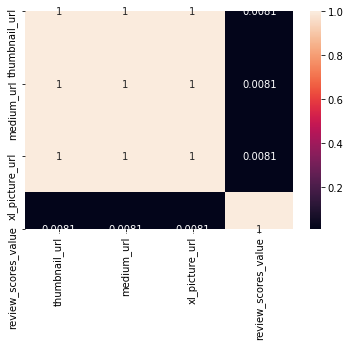

In [18]:
sns.heatmap(data=dummyDataForPicture.corr(), annot=True)

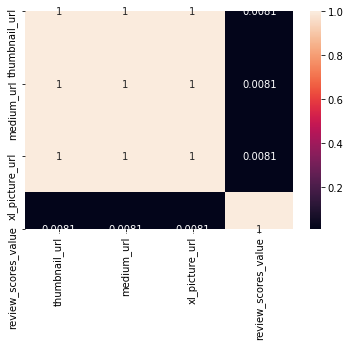

In [19]:
sns.heatmap(dataForPictureQuestion.corr(), annot=True)

In [20]:
listingsWithPictures.shape

(2905, 4)

In [21]:
listings.shape

(3818, 92)

In [22]:
countDF = {'review_scores_value':[], 'count':[]}
for rating in listingsWithPictures['review_scores_value'].unique():
    countDF['review_scores_value'].append(rating)
    countDF['count'].append(len(listingsWithPictures[listingsWithPictures['review_scores_value'] == rating]))

In [25]:
reviewCount = pd.DataFrame.from_dict(data=countDF)

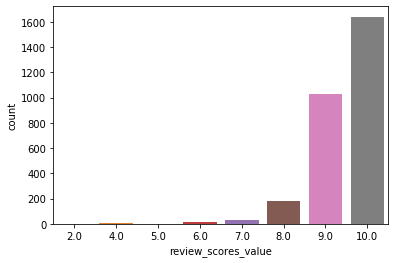

In [26]:
sns.barplot(x=reviewCount['review_scores_value'], y=reviewCount['count'], data=reviewCount)

In [27]:
totalCountDict = {'review_scores_value':[], 'count':[]}
for rating in listings['review_scores_value'].unique():
    totalCountDict['review_scores_value'].append(rating)
    if pd.notnull(rating): 
        totalCountDict['count'].append(len(listings[listings['review_scores_value'] == rating]))
    else: 
        totalCountDict['count'].append(len(listings[listings['review_scores_value'].isnull()]))

In [28]:
countDF

{'review_scores_value': [10.0, 9.0, 8.0, 6.0, 7.0, 4.0, 2.0, 5.0],
 'count': [1640, 1032, 179, 15, 33, 4, 1, 1]}

In [29]:
totalCountDict

{'review_scores_value': [10.0, nan, 9.0, 8.0, 7.0, 6.0, 4.0, 2.0, 5.0],
 'count': [1775, 656, 1137, 190, 38, 16, 4, 1, 1]}

In [30]:
totalCountDF = pd.DataFrame.from_dict(totalCountDict)

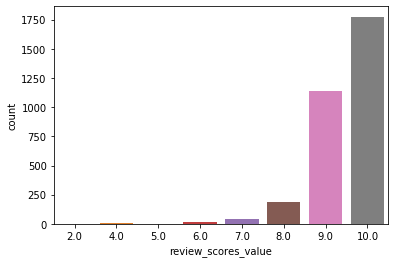

In [31]:
sns.barplot(x='review_scores_value', y='count', data=totalCountDF)

# Does not having a picture correlate to not having a review?

In [32]:
noReviewScores = listings[listings['review_scores_value'].isna()]

In [33]:
noThumbnailURL = listings[listings['thumbnail_url'].isnull()]

In [34]:
merged = noReviewScores.merge(noThumbnailURL)

In [35]:
merged.shape

(63, 92)

In [36]:
noThumbnailURL.shape

(320, 92)

In [37]:
noReviewScores[noReviewScores['thumbnail_url'].isnull()].shape

(63, 92)

The investigation from above does not have any good insight from what I can that leads from having one picture correlate to higher review rating. 

# Is square feet correlated to price?

In [38]:
listings['square_feet'].isna().sum()

3721

In [39]:
listings.shape

(3818, 92)

In [40]:
not_null_square_feet = listings[listings['square_feet'].notnull()]

In [41]:
not_null_square_feet.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
96,20927,https://www.airbnb.com/rooms/20927,20160104002432,2016-01-04,Cottage in the Heart of Ballard,A cozy cottage behind a lovely Victorian hous...,A cozy cottage behind a lovely Victorian house...,A cozy cottage behind a lovely Victorian hous...,none,Ballard is a fantastic destination neighborhoo...,Golden Gardens Park on Puget Sound is a mile a...,Convenient and frequent bus service to downtow...,https://a1.muscache.com/ac/pictures/234452/3f9...,https://a1.muscache.com/im/pictures/234452/3f9...,https://a1.muscache.com/ac/pictures/234452/3f9...,https://a1.muscache.com/ac/pictures/234452/3f9...,79450,https://www.airbnb.com/users/show/79450,Brad & Liz,2010-02-09,"Seattle, Washington, United States","(Facebook+) Likes:\r\nLIZ: Drawing, Painting, ...",within an hour,100%,100%,t,https://a1.muscache.com/ac/users/79450/profile...,https://a1.muscache.com/ac/users/79450/profile...,Ballard,2.0,2.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"NW 60th St, Seattle, WA 98107, United States",Ballard,Adams,Ballard,Seattle,WA,98107,Seattle,"Seattle, WA",US,United States,47.673339,-122.39512,t,Cabin,Entire home/apt,2,1.0,1.0,1.0,Futon,"{TV,""Cable TV"",Internet,""Wireless Internet"",""F...",400.0,$89.00,$549.00,NaN,NaN,$10.00,2,$0.00,2,14,today,t,10,40,70,341,2016-01-04,244,2010-07-04,2015-12-26,97.0,10.0,9.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,t,moderate,f,f,2,3.64
103,1579615,https://www.airbnb.com/rooms/1579615,20160104002432,2016-01-04,"Ballard, Seattle Cozy Studio Apt.","Nice, clean, cozy home apt-studio in the h...",This beautiful home apartment studio is locate...,"Nice, clean, cozy home apt-studio in the h...",none,Ballard is a very nice neighborhood with lots ...,NaN,NaN,https://a0.muscache.com/ac/pictures/67825250/5...,https://a0.muscache.com/im/pictures/67825250/5...,https://a0.muscache.com/ac/pictures/67825250/5...,https://a0.muscache.com/ac/pictures/67825250/5...,8403307,https://www.airbnb.com/users/show/8403307,Mario,2013-08-26,"Seattle, Washington, United States","Originally from Havana, Cuba where I was born ...",within an hour,100%,100%,t,https://a2.muscache.com/ac/users/8403307/profi...,https://a2.muscache.com/ac/users/8403307/profi...,Ballard,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Northwest 64th Street, Seattle, WA 98107, Unit...",Ballard,Adams,Ballard,Seattle,WA,98107,Seattle,"Seattle, WA",US,United States,47.675822,-122.38971,t,House,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",485.0,$97.00,$590.00,"$1,795.00",$100.00,$45.00,2,$10.00,2,1125,today,t,21,47,77,340,2016-01-04,

In [42]:
not_null_square_feet[['square_feet','price']]

,square_feet,price
96,400.0,$89.00
103,485.0,$97.00
163,800.0,$120.00
182,450.0,$95.00
196,1.0,$180.00
...,...,...
3649,340.0,$125.00
3652,350.0,$68.00
3654,250.0,$86.00
3776,660.0,$115.00


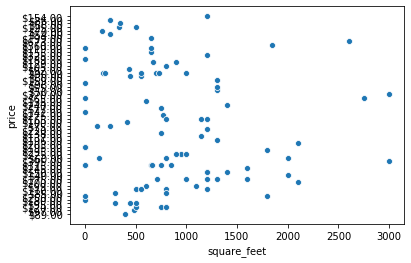

In [43]:
sns.scatterplot(data=not_null_square_feet,x='square_feet',y='price')

Since there is only 97 rows with square feet not null, this questions will be excluded from investigation <br>
However, from the data present, there isn't any notable correlation between price and square feet

# What feature correlates to higher prices? 

In [69]:
def clean_price_column(x):
    return x.replace('$', '').replace(',','')

In [70]:
listings['price'] = listings['price'].apply(clean_price_column).astype('float64')

In [71]:
y=listings['price']

In [74]:
startingListings = listings.select_dtypes(include=['double','int'])

Dropping latitude and longitude from the dataset, because they have unique values for the entire dataset, and could be trained to be a 1-1 relationship with price.<br> 
Also dropping license, because it has all null values for this dataset. 

In [84]:
x = startingListings.drop(['price','latitude','longitude','license'],axis=1)

In [85]:
x.columns

Index(['host_listings_count', 'host_total_listings_count', 'bathrooms',
       'bedrooms', 'beds', 'square_feet', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [90]:
x.isna().sum()

host_listings_count               2
host_total_listings_count         2
bathrooms                        16
bedrooms                          6
beds                              1
square_feet                    3721
review_scores_rating            647
review_scores_accuracy          658
review_scores_cleanliness       653
review_scores_checkin           658
review_scores_communication     651
review_scores_location          655
review_scores_value             656
reviews_per_month               627
dtype: int64

In [92]:
x.shape

(3818, 14)

In [91]:
x.describe()

,host_listings_count,host_total_listings_count,bathrooms,bedrooms,beds,square_feet,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,3816.000000,3816.000000,3802.000000,3812.000000,3817.000000,97.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3191.000000
mean,7.157757,7.157757,1.259469,1.307712,1.735394,854.618557,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.078919
std,28.628149,28.628149,0.590369,0.883395,1.139480,671.404893,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,1.822348
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,0.020000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,420.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.695000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,750.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.540000
75%,3.000000,3.000000,1.000000,2.000000,2.000000,1200.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000
max,502.000000,502.000000,8.000000,7.000000,15.000000,3000.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.150000


In [95]:
filled_na = x.fillna(-1)

In [96]:
x_train, x_test, y_train, y_test = train_test_split(filled_na, y, test_size=.33, random_state=42)

In [97]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [98]:
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [101]:
pred = reg.predict(x_test)

In [102]:
reg.coef_

array([ 3.37196587e-02,  3.37196587e-02,  2.83759856e+01,  2.97342431e+01,
        2.10796553e+01,  1.26131874e-02,  1.13156990e-01,  4.68037602e+00,
        5.69468446e+00, -4.97643082e+00, -3.29403611e+00,  1.11762317e+01,
       -1.36859553e+01, -4.18260537e+00])

Based on the coefficients for the logistical model, it looks like the three highest attributes to determine price is bathrooms, bedrooms and beds. 